In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Applied_AI_project/dataset_2.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset_2/late blight/LB_ (264).png  
  inflating: __MACOSX/dataset_2/late blight/._LB_ (264).png  
  inflating: dataset_2/late blight/e980207c-6e67-4caf-8973-7128ca2a1c12___GHLB2 Leaf 8876.JPG  
  inflating: __MACOSX/dataset_2/late blight/._e980207c-6e67-4caf-8973-7128ca2a1c12___GHLB2 Leaf 8876.JPG  
  inflating: dataset_2/late blight/953f355a-fd2c-433e-8292-a8c1908e000e___GHLB2 Leaf 8853.JPG  
  inflating: __MACOSX/dataset_2/late blight/._953f355a-fd2c-433e-8292-a8c1908e000e___GHLB2 Leaf 8853.JPG  
  inflating: dataset_2/late blight/tomato_D33a-Late-blight-015-OMAFHRT_zoom_jpg.rf.054f2a0a7ad993f4cf6e4372933cd5bc.jpg  
  inflating: __MACOSX/dataset_2/late blight/._tomato_D33a-Late-blight-015-OMAFHRT_zoom_jpg.rf.054f2a0a7ad993f4cf6e4372933cd5bc.jpg  
  inflating: dataset_2/late blight/0b52ebed-e711-41f2-bfd1-af73410b370e___RS_Late.B 5463_flipLR.JPG  
  inflating: __MACOSX/dataset_2/late blight/._0b52ebed-e711-41f2-bfd1-af7

In [3]:
DATASET_TYPE = 'dataset_2'
ARCHITECTURE = 'mobilenet'

In [4]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v2

import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns

In [7]:
# splitting the dataset into specific folders for train, validate and test
!pip install split-folders
import splitfolders

source_folder = f'{DATASET_TYPE}'
target_folder = f'{DATASET_TYPE}_splitted'

train_ratio = .7
val_ratio = .15
test_ratio = .15

splitfolders.ratio(source_folder, output=target_folder, seed=1337, ratio=(train_ratio, val_ratio, test_ratio), group_prefix=None, move=False)

Copying files: 14658 files [00:06, 2359.37 files/s]


In [8]:
# applying data prepocessing and loading dataset
train_dataset_tranform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset_tranform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(f"{DATASET_TYPE}_splitted/train", transform=train_dataset_tranform)
train_length = len(train_dataset)

validate_dataset = ImageFolder(f"{DATASET_TYPE}_splitted/val", transform=test_dataset_tranform)
validate_length = len(validate_dataset)

test_dataset = ImageFolder(f"{DATASET_TYPE}_splitted/test", transform=test_dataset_tranform)
test_dataset_length = len(test_dataset)

dataset_classes = train_dataset.classes
print(dataset_classes)

['early blight', 'healthy', 'late blight', 'mosaic virus', 'powdery mildew', 'septoria']


In [9]:
# setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
# modifying architecture output classes
class MobileNetV2(nn.Module):
  def __init__(self, num_of_classes):
    super(MobileNetV2, self).__init__()
    self.model = mobilenet_v2(weights=None)
    features = self.model.classifier[-1].in_features
    self.model.classifier[-1] = nn.Linear(features, num_of_classes)

  def forward(self, x):
    x = self.model(x)
    return x

In [12]:
# Training model using different batch sizes

batch_sizes = [32, 64, 128]

for batch_size in (batch_sizes):

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  learning_rate = 0.001
  epochs = 15

  model = MobileNetV2(num_of_classes=len(dataset_classes))
  model = model.to(device)
  optimizer = Adam(model.parameters(), lr=learning_rate)
  loss_function = CrossEntropyLoss()

  train_losses = []
  train_accuracies = []
  validate_losses = []
  validate_accuracies = []

  print(f"batch size: ---------------> {batch_size}")

  for epoch in range(epochs):

    print(f"epoch number ---> {epoch + 1} ")

    model.train()
    train_batch_loss = 0.0
    train_correct_predictions = 0
    train_samples = 0
    for xtrain, ytrain in train_loader:

      optimizer.zero_grad()

      xtrain = xtrain.to(device)
      ytrain = ytrain.to(device)
      train_prob = model(xtrain)

      # calculating batch accuracy
      _, train_prediction = torch.max(train_prob, 1)
      train_samples += ytrain.size(0)
      train_correct_predictions += (train_prediction == ytrain).sum().item()

      loss = loss_function(train_prob, ytrain)
      loss.backward()
      optimizer.step()

      # calculating batch loss
      train_batch_loss += loss.item()

    # calculating train loss for epoch
    train_loss = train_batch_loss / len(train_loader)
    train_losses.append(train_loss)

    # calculating train accuracy for epoch
    train_accuracy = 100 * (train_correct_predictions / train_samples)
    train_accuracies.append(train_accuracy)
    print("training loss: {:.4f}  training accuracy: {:.2f} %".format(train_loss, train_accuracy))

    validate_batch_loss = 0.0
    validate_correct_predictions = 0
    validate_samples = 0
    model.eval()
    with torch.no_grad():
      for xvalidate, yvalidate in validate_loader:

        optimizer.zero_grad()

        xvalidate = xvalidate.to(device)
        yvalidate = yvalidate.to(device)
        validate_prob = model(xvalidate)

        #calculating batch accuracy
        _, validate_prediction = torch.max(validate_prob, 1)
        validate_samples += yvalidate.size(0)
        validate_correct_predictions += (validate_prediction == yvalidate).sum().item()

        loss = loss_function(validate_prob, yvalidate)

        #calculating batch loss
        validate_batch_loss += loss.item()

    # calculating validate loss for epoch
    validate_loss = validate_batch_loss / len(validate_loader)
    validate_losses.append(validate_loss)

    # calculating validate accuracy for epoch
    validate_accuracy = 100 * (validate_correct_predictions / validate_samples)
    validate_accuracies.append(validate_accuracy)
    print("validation loss: {:.4f}  validation accuracy: {:.2f} %".format(validate_loss, validate_accuracy))

  print(f"training and validation for {epochs} epochs completed")
  print(f"train losses: {train_losses}")
  print(f"train accuracies: {train_accuracies}")
  print(f"validation losses: {validate_losses}")
  print(f"validation accuracies: {validate_accuracies}")

  # saving metrics to a file
  np.savez(f'{ARCHITECTURE}_{batch_size}_metrics.npz',
          train_losses=train_losses,
          train_accuracies=train_accuracies,
          validate_losses=validate_losses,
          validate_accuracies=validate_accuracies)

batch size: ---------------> 32
epoch number ---> 1 
training loss: 1.3233  training accuracy: 46.70 %
validation loss: 1.3891  validation accuracy: 54.31 %
epoch number ---> 2 
training loss: 1.0299  training accuracy: 60.11 %
validation loss: 0.8311  validation accuracy: 68.56 %
epoch number ---> 3 
training loss: 0.9112  training accuracy: 64.92 %
validation loss: 0.8614  validation accuracy: 66.38 %
epoch number ---> 4 
training loss: 0.8454  training accuracy: 67.97 %
validation loss: 0.8030  validation accuracy: 70.52 %
epoch number ---> 5 
training loss: 0.8099  training accuracy: 68.89 %
validation loss: 0.6670  validation accuracy: 74.49 %
epoch number ---> 6 
training loss: 0.7617  training accuracy: 70.55 %
validation loss: 0.6343  validation accuracy: 75.08 %
epoch number ---> 7 
training loss: 0.7038  training accuracy: 73.20 %
validation loss: 0.6425  validation accuracy: 76.36 %
epoch number ---> 8 
training loss: 0.6677  training accuracy: 74.58 %
validation loss: 0.737

In [2]:
data_32 = np.load('mobilenet_32_metrics.npz')
data_64 = np.load('mobilenet_64_metrics.npz')
data_128 = np.load('mobilenet_128_metrics.npz')

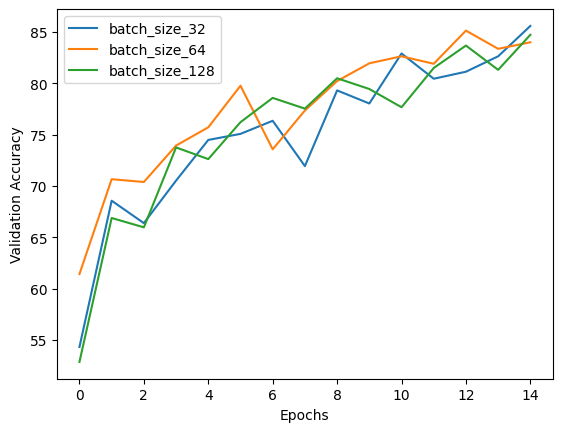

In [3]:
accuracy_32 = data_32['validate_accuracies']
accuracy_64 = data_64['validate_accuracies']
accuracy_128 = data_128['validate_accuracies']

plt.plot(accuracy_32,label='batch_size_32')
plt.plot(accuracy_64,label='batch_size_64')
plt.plot(accuracy_128,label='batch_size_128')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

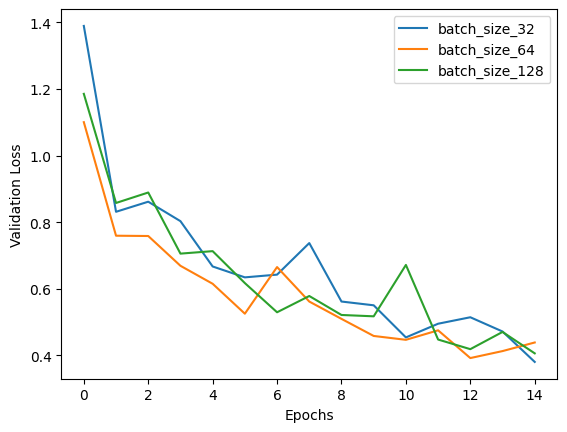

In [5]:
loss_32 = data_32['validate_losses']
loss_64 = data_64['validate_losses']
loss_128 = data_128['validate_losses']

plt.plot(loss_32,label='batch_size_32')
plt.plot(loss_64,label='batch_size_64')
plt.plot(loss_128,label='batch_size_128')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()